# Sessie 04 -  Natural Language Processing

Sinds enkele jaren schieten de Natural Language Processing toepassingen als paddenstoelen uit de grond. Eén van de belangrijkste redenen daarvoor is de steeds groter wordende beschikbaarheid van tekstuele data aangeleverd door bijvoorbeeld social media.

In deze opdracht zal NLP toegepast worden in het kader van sentiment analysis. De bedoeling van sentiment analysis is om uit een tekstueel bericht zoals een email, sms, twitter bericht, Trip Advisor review het sentiment te voorspellen. Bedrijven weten bijvoorbeeld graag wat het sentiment is in de berichten die online over hen verschijnen.

De opdracht bestaat uit 2 deelopdrachten.

De eerste deelopdracht gaat rond het uitvoeren van pure sentiment analysis van Tweets.
Bij de tweede deelopdracht is het de bedoeling om cyber trolls op te sporen.

Telkens wordt het bag-of-words model gebruikt om tekst voor te stellen en vervolgens worden verschillende classifiers getraind om het sentiment/rating te voorspellen.

Het bag-of-words model beschrijft het voorkomen van woorden binnen een document en doet dit op bais van een vocabulair van gekende woorden en meet de aanwezigheid van deze gekende woorden. De grote beperking van het bag-of-words model is dat het enkel rekening houdt met welke woorden in een bericht voorkomen en niet met de volgorde ervan. Daardoor is het bag-of-words model heel beperkt in het capteren van de context waarin woorden in een bericht voorkomen . Tijdens de module deep learning zullen we afstappen van het bag-of-words model en gebruik maken van word embeddings in combinatie met LSTM neurale netwerken. Op deze manier kunnen we modellen trainen die wel rekening houden met de context en woordvolgordes.

In [177]:
%matplotlib inline
import timeit
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import roc_curve, auc, det_curve

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV

import nltk
import seaborn as sns
from nltk.corpus import stopwords
nltk.download('stopwords')
import re #regular expressions
from bs4 import BeautifulSoup
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from scipy.sparse import csr_matrix

pd.set_option('display.max_rows',1000)
pd.set_option('display.max_columns',1000)
pd.set_option('display.max_colwidth',150)

# Eigen functies
def ismissing(df):
    all_columns = df.columns

    missing_arr = []
    missing_column = ['Column name', 'Number of missing values']

    for c in all_columns:
        mv = airline[c].isnull().sum()
        if mv != 0:
            missing_row = [c, mv]
            missing_arr.append(missing_row)
    
    if not missing_arr:
        print("Er zijn geen ontbrekende waarden")
    else:
        missing_df = pd.DataFrame(missing_arr, columns = missing_column)
        return missing_df

# Functie ontleend aan de cursus en aangepast (bron: Wouter Gevaert, Notebook Naive Bayes demo)
def text_preprocessing(text):
    
    # remove html
    text_no_html = BeautifulSoup(str(text),"html.parser" ).get_text()
    
    # remove non-letters
    text_alpha_chars = re.sub("[^a-zA-Z']", " ", str(text_no_html)) 
        
    # convert to lower-case
    text_lower = text_alpha_chars.lower()
    
    # remove stop words
    stops = set(stopwords.words(language)) 
    text_no_stop_words = ' '
    
    for w in text_lower.split():
        if w not in stops:  
            text_no_stop_words = text_no_stop_words + w + ' '
      
       # do stemming
    text_stemmer = ' '
    stemmer = SnowballStemmer('english')
    for w in text_no_stop_words.split():
        text_stemmer = text_stemmer + stemmer.stem(w) + ' '
         
    # remove short words
    text_no_short_words = ' '
    for w in text_stemmer.split(): 
        if len(w) >= 2:
            text_no_short_words = text_no_short_words + w + ' '
 

    return text_no_short_words

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gbroe\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Airline sentiment

De dataset 'Airlines_sentiment.csv' bevat tweets over verschillende airlines. Jouw taak bestaat erin om een classifier te trainen die zo goed mogelijk het sentiment van de tweets kan classificeren als positive, neutral en negative.
Het sentiment bevindt zich in de kolom 'airline_sentiment' en de tweet zelf in de kolom 'text'.
Doorloop de volgende stappen:
- Analyse van de data
- Preprocessing
- Training en hyperparameter tuning
- Modeloptimalisatie


In [133]:
# Inlezen van de dataset

airline = pd.read_csv('Airline_sentiment.csv',encoding = 'ISO-8859-1')
airline.tail()

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,airline_sentiment,airline_sentiment:confidence,negativereason,negativereason:confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_id,tweet_location,user_timezone
14635,681679794,False,finalized,3,2/25/15 19:46,positive,0.3487,NaN,0.0000,American,NaN,KristenReenders,NaN,0,@AmericanAir thank you we got on a different flight to Chicago.,NaN,2/22/15 12:01,5.695880e+17,NaN,NaN
14636,681679795,False,finalized,3,2/25/15 19:14,negative,1.0000,Customer Service Issue,1.0000,American,NaN,itsropes,NaN,0,@AmericanAir leaving over 20 minutes Late Flight. No warnings or communication until we were 15 minutes Late Flight. That's called shitty customer...,NaN,2/22/15 11:59,5.695870e+17,Texas,NaN
14637,681679796,False,finalized,3,2/25/15 19:04,neutral,1.0000,NaN,NaN,American,NaN,sanyabun,NaN,0,@AmericanAir Please bring American Airlines to #BlackBerry10,NaN,2/22/15 11:59,5.695870e+17,"Nigeria,lagos",NaN
14638,681679797,False,finalized,3,2/25/15 18:59,negative,1.0000,Customer Service Issue,0.6659,American,NaN,SraJackson,NaN,0,"@AmericanAir you have my money, you change my flight, and don't answer your phones! Any other suggestions so I can make my commitment??",NaN,2/22/15 11:59,5.695870e+17,New Jersey,Eastern Time (US & Canada)
14639,681679798,False,finalized,3,2/25/15 19:06,neutral,0.6771,NaN,0.0000,American,NaN,daviddtwu,NaN,0,@AmericanAir we have 8 ppl so we need 2 know how many seats are on the next flight. Plz put us on standby for 4 people on the next flight?,NaN,2/22/15 11:58,5.695870e+17,"dallas, TX",NaN


In [134]:
airline.shape

(14640, 20)

### Analyse van de dataset

- Onderzoek de gebalanceerdheid van de dataset. Stel grafisch de verdeling voor van het sentiment.
- Visualiseer de verdeling van het sentiment per airline. Maak daarvoor per airline een Seaborn countplot van het sentiment.
- Welke airline lijkt op basis van deze tweet het best te scoren en welke het slechtst?
- Uit hoeveel woorden bestaat het langste twitter bericht en uit hoeveel woorden het kortste?

#### Gebalanceerdheid van de dataset
Door middel van een countplot wordt de gebalanceerdheid van de dataset weergegeven. Vervolgens worden de absolute waarden en frequenties weergegeven.

<AxesSubplot:xlabel='airline_sentiment', ylabel='count'>

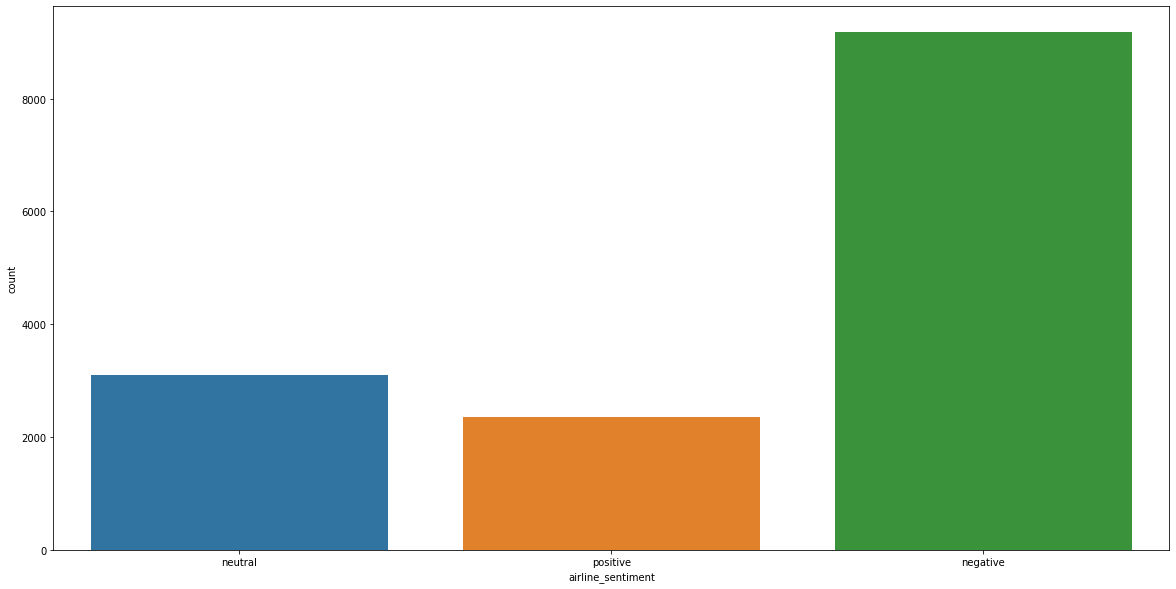

In [135]:
# Gebalanceerdheid van de dataset
sns.countplot(x="airline_sentiment", data=airline)

In [136]:
airline['airline_sentiment'].value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

In [137]:
airline['airline_sentiment'].value_counts(normalize=True)

negative    0.626913
neutral     0.211680
positive    0.161407
Name: airline_sentiment, dtype: float64

**Conclusie**: de dataset is niet gebalanceerd. Er is een dominantie van de categorie "negative". De minderheidsklase is "positive". De verdeling van de drie klassen volgens frequentie is als volgt:
- "negative": 63%
- "neutral": 21%
- "positive": 16%

#### Verdeling van het sentiment per airline
De verdeling van het sentiment per airline wordt weergegeven doormiddel van onderstaande countplots. De eerste groepeert de airline volgens sentiment, de tweede vice versa.

<AxesSubplot:xlabel='airline_sentiment', ylabel='count'>

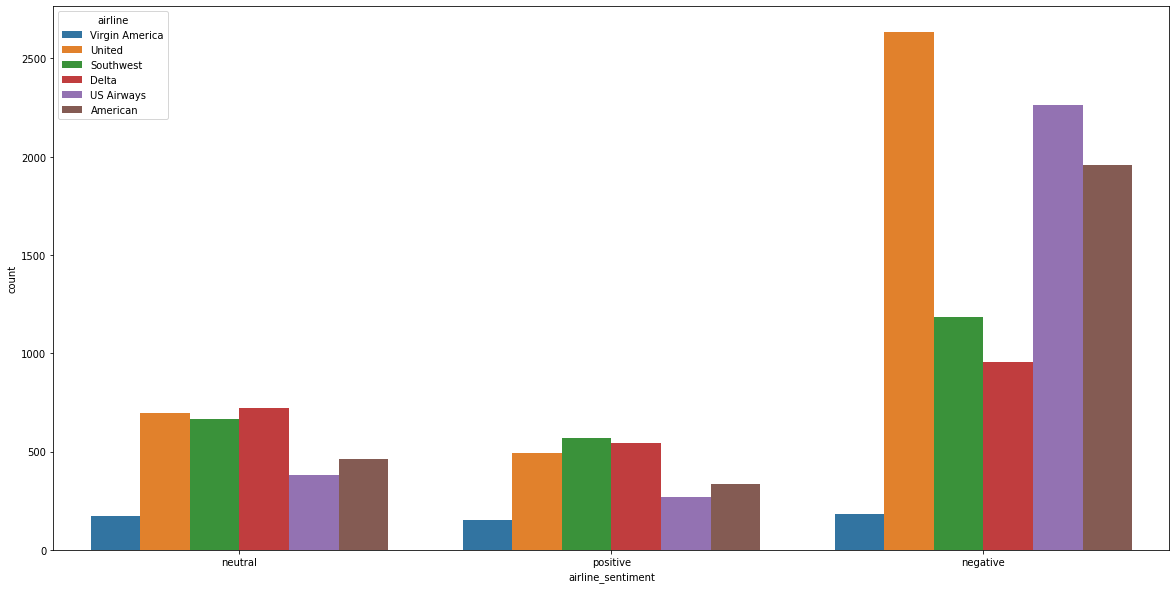

In [138]:
sns.countplot(x="airline_sentiment", data=airline, hue="airline")

<AxesSubplot:xlabel='airline', ylabel='count'>

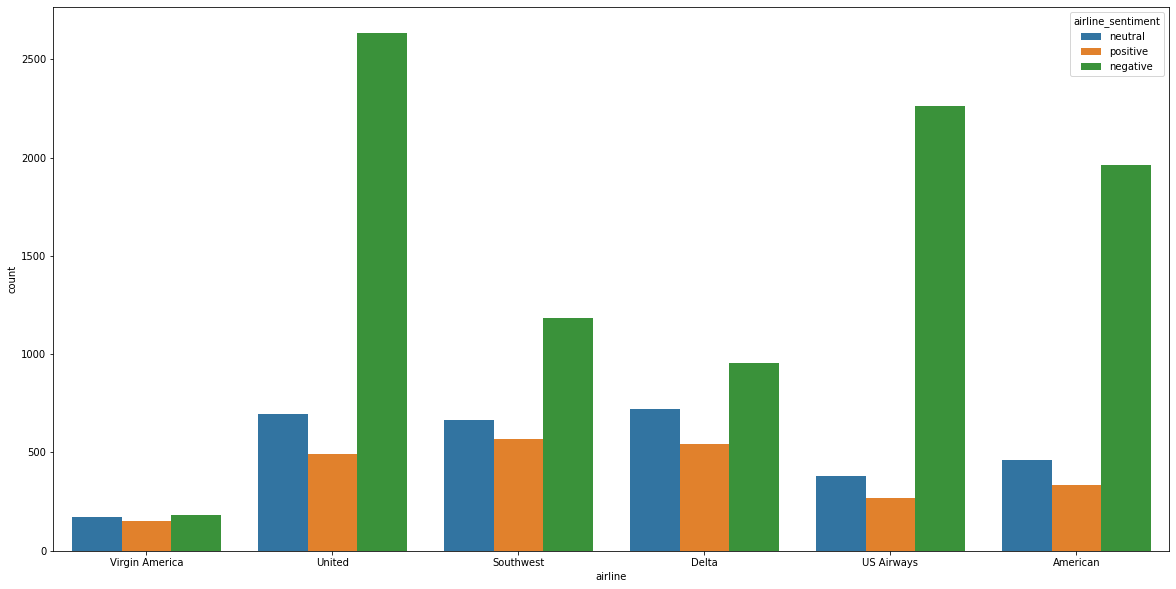

In [139]:
sns.countplot(x="airline", data=airline, hue="airline_sentiment")

#### Beste en slechtste sentiments
Op basis van voorgaande countplots valt op dat de airline "United" de meeste tweets hebben met een negative sentiment. United wordt gevolgd door "US Airways" en "American".

De airline met de meeste tweets met een positieve sentiment is "Southwest", dicht gevolgd door "Delta" en "United".

Om te kijken naar welke airline het nu echt het beste deed, lijkt het nuttig om te kijken naar de verhouding tussen negatieve en positieve sentimenten. Deze verhouding is het beste bij "Virgin America". Bij deze airline nadert deze een 1:1 ratio. Belangrijke nota bij deze airline: het totaal aantal tweets is veel lager dan deze voor andere airlines. De slechtste verhouding tussen positieve en negatieve sentimenten wordt gezien bij "US Airways", gevolgd door "United" en "American".

#### Langste en kortste twitterberichten
Het aantal woorden wordt geteld en de min waarde en max waarde worden hieronder weergegeven.

In [140]:
airline['word_count'] = airline.text.apply(lambda x: len(str(x).split(' ')))
print(f"Het aantal woorden in het kortste bericht: \t{airline.word_count.min():3d} \t\t Dataframe index: \t{airline.word_count.idxmin():4d}")
print(f"Het aantal woorden in het langste bericht: \t{airline.word_count.max():3d} \t\t Dataframe index: \t{airline.word_count.idxmax():4d}")


Het aantal woorden in het kortste bericht: 	  2 		 Dataframe index: 	  14
Het aantal woorden in het langste bericht: 	 36 		 Dataframe index: 	8062


Het kortste twitterbericht heeft slechts 2 woorden. Dit twitter bericht kan in de Pandas Dataframe worden gevonden in de rij met index 14.

Het langste twitterbericht heeft 36 woorden. Dit twitter bericht kan in de Pandas Dataframe worden gevonden in de rij met index 8062.

In [142]:
airline['length'] = airline.text.apply(len)
airline.head()

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,airline_sentiment,airline_sentiment:confidence,negativereason,negativereason:confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_id,tweet_location,user_timezone,word_count,length
0,681448150,False,finalized,3,2/25/15 5:24,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2/24/15 11:35,5.703060e+17,NaN,Eastern Time (US & Canada),4,35
1,681448153,False,finalized,3,2/25/15 1:53,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials to the experience... tacky.,NaN,2/24/15 11:15,5.703010e+17,NaN,Pacific Time (US & Canada),9,72
2,681448156,False,finalized,3,2/25/15 10:01,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I need to take another trip!,NaN,2/24/15 11:15,5.703010e+17,Lets Play,Central Time (US & Canada),12,71
3,681448158,False,finalized,3,2/25/15 3:05,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",NaN,2/24/15 11:15,5.703010e+17,NaN,Pacific Time (US & Canada),17,126
4,681448159,False,finalized,3,2/25/15 5:50,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing about it,NaN,2/24/15 11:14,5.703010e+17,NaN,Pacific Time (US & Canada),10,55


### Preprocessing

Onderzoek of er mogelijks foutieve of ontbrekende data aanwezig is. 
Kuis de tweets op: verwijder stopwoorden en niet-letters, zet alles om naar lowercase en pas stemming toe.
Maak gebruik van de CountVectorizer en TfidfTransformer om een bag-of-words model te creëren. 

Meer info: 

https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html 

https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html#sklearn.feature_extraction.text.TfidfTransformer 

https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn.feature_extraction.text.TfidfVectorizer

Splits op in een training set en test set. Zorg ervoor dat er 3000 tweets in de test set steken.


In [143]:
# Ontbrekende data
ismissing(airline)

,Column name,Number of missing values
0,_last_judgment_at,56
1,negativereason,5462
2,negativereason:confidence,4118
3,airline_sentiment_gold,14600
4,negativereason_gold,14608
5,tweet_coord,13621
6,tweet_location,4733
7,user_timezone,4820


#### Ontbrekende, foutieve en niet-informatieve waarden
Het totaal aantal observaties is 14640. Dat betekent dat de meerderheid van de waarden van de kolommen 'airline_sentiment_gold', 'negativereason_gold' en 'tweet_coord' een missing value betreft. Verwijderen van deze kolommen hebben meer zin dan het verwijderen van observaties, want anders blijven er niet veel observaties meer over in de dataset.

De kolom '_last_judgment_at' heeft geen informatieve betekenis in de sentimentanalyse van de twitterberichten en zal daarom ook worden verwijderd. 

De kolom 'negativereason' geeft een waarde die enkel wordt gegeven indien de uitkomst van de sentimentanalyse 'negative' is. Deze kolom heeft met andere woorde geen betekenis indien de sentiment 'positive' of 'neutral zou zijn. Dezelfde redenering kan worden gemaakt met 'negativereason:confidence'. Ook de algemene 'airline_sentiment:confidence' zou een waarde moeten zijn, die berekend dient te worden na evaluatie. Dit lijkt eveneens geen waarde, dat gegeven zal worden bij nieuwe voorspellingen.

Tenslotte zou de tijdzone van de gebruiker geen invloed mogen hebben op het sentiment van een bericht. Daarom worden de kolommen 'user_timezone' en 'tweet_location' eveneens geschrapt. Deze laatste kolom bevatte bovendien veel foutieve waarden.

Andere kolommen, zonder ontbrekende waarden, die verder geen informatieve waarden hebben, worden verwijderd. Dit zijn de kolommen: '_unit_id', '_unit_state' 'name', 'tweet_created' en 'tweet_id'.

Hieronder wordt een overzicht gegeven van de overgebleven kolommen. Voor elke kolom met uitzondering van de 'text'-kolom zal aan de hand van countplots of wordt bekeken of deze features een impact hebben op het sentiment van een twitterbericht.

In [144]:
column_drop = ['airline_sentiment_gold', 'negativereason_gold', 'tweet_coord', 
               '_last_judgment_at', 'negativereason:confidence', 'negativereason', 
               '_unit_id', '_unit_state', 'name', 'tweet_created' , 'tweet_id', 
               'user_timezone', 'airline_sentiment:confidence', 'tweet_location']
airline.drop(column_drop, axis=1, inplace=True)
airline.head()

,_golden,_trusted_judgments,airline_sentiment,airline,retweet_count,text,word_count,length
0,False,3,neutral,Virgin America,0,@VirginAmerica What @dhepburn said.,4,35
1,False,3,positive,Virgin America,0,@VirginAmerica plus you've added commercials to the experience... tacky.,9,72
2,False,3,neutral,Virgin America,0,@VirginAmerica I didn't today... Must mean I need to take another trip!,12,71
3,False,3,negative,Virgin America,0,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",17,126
4,False,3,negative,Virgin America,0,@VirginAmerica and it's a really big bad thing about it,10,55


<AxesSubplot:xlabel='_golden', ylabel='count'>

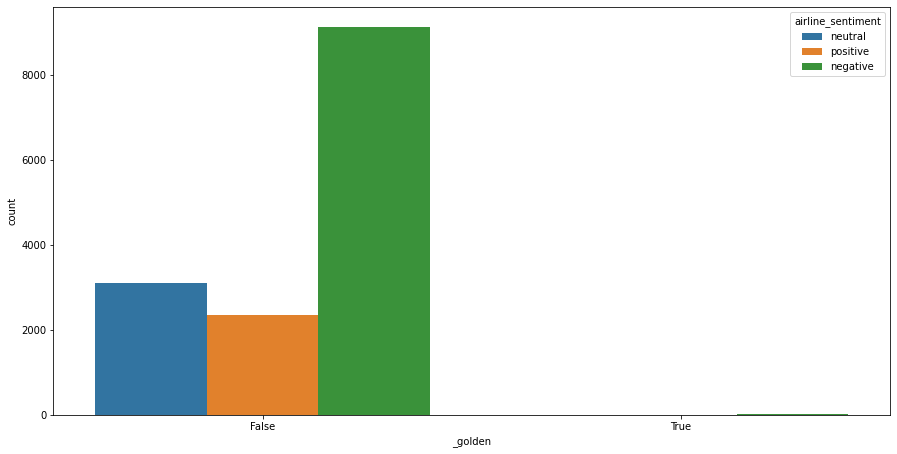

In [145]:
plt.rcParams['figure.figsize'] = 15,7.5
sns.countplot(x='_golden', hue='airline_sentiment', data=airline)


In [146]:
golden = airline.groupby(['_golden','airline_sentiment']).size().reset_index()
golden

,_golden,airline_sentiment,0
0,False,negative,9146
1,False,neutral,3096
2,False,positive,2358
3,True,negative,32
4,True,neutral,3
5,True,positive,5


<AxesSubplot:xlabel='_trusted_judgments', ylabel='count'>

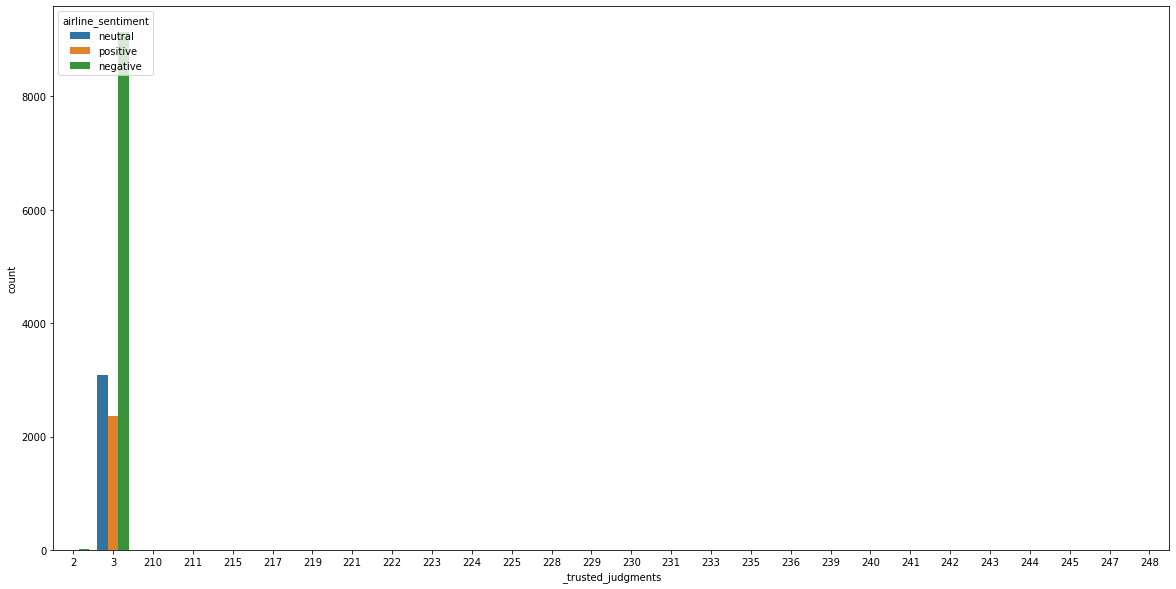

In [147]:
plt.rcParams['figure.figsize'] = 20,10
sns.countplot(x='_trusted_judgments', hue='airline_sentiment', data=airline)

In [148]:
trusted = airline.groupby(['_trusted_judgments','airline_sentiment']).size().reset_index()
trusted

,_trusted_judgments,airline_sentiment,0
0,2,negative,14
1,2,neutral,3
2,2,positive,2
3,3,negative,9132
4,3,neutral,3093
5,3,positive,2356
6,210,negative,1
7,211,negative,1
8,215,negative,3
9,217,negative,1


<AxesSubplot:xlabel='retweet_count', ylabel='count'>

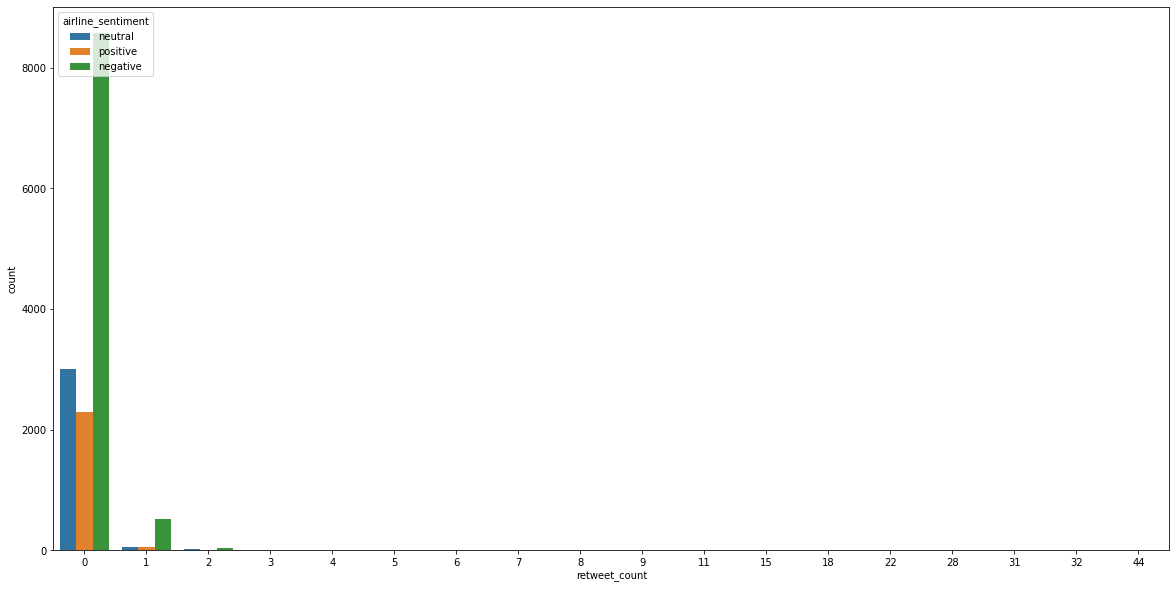

In [149]:
sns.countplot(x='retweet_count', hue='airline_sentiment', data=airline)

In [150]:
retweet = airline.groupby(['retweet_count','airline_sentiment']).size().reset_index()
retweet

,retweet_count,airline_sentiment,0
0,0,negative,8581
1,0,neutral,3005
2,0,positive,2287
3,1,negative,524
4,1,neutral,63
5,1,positive,53
6,2,negative,41
7,2,neutral,16
8,2,positive,9
9,3,negative,12


De verhoudingen tussen negatieve, positieve en neutrale sentimenten verschilt nagenoeg niet voor de verschillende waarden van de kolommen '_golden', '_trusted_judgments'. Op basis van dit gegeven worden deze kolommen verwijderd.

Voor het feature 'retweet_count' lijkt de verhouding tussen negatieve en positieve tweets te verkleinen, naarmate er meer retweets zijn. Het nadeel van dit feature is dat er enkele combinaties tussen sentiment en aantal retweets niet bestaan. Laplacian smoothing moet voor deze combinaties dan compenseren. In verdere modellen wordt er straks getest of dit feature kan helpen bij sentiment analyse.

De kolom 'tweet_location' bevat vreemde waarden. Deze kolom zal bijgevolg ook worde geschrapt.

Hieronder volgt een overzicht van de overgebleven dataset.

In [151]:
column_drop2 = ['_golden', '_trusted_judgments']
airline.drop(column_drop2, axis=1, inplace=True)
airline.head()

,airline_sentiment,airline,retweet_count,text,word_count,length
0,neutral,Virgin America,0,@VirginAmerica What @dhepburn said.,4,35
1,positive,Virgin America,0,@VirginAmerica plus you've added commercials to the experience... tacky.,9,72
2,neutral,Virgin America,0,@VirginAmerica I didn't today... Must mean I need to take another trip!,12,71
3,negative,Virgin America,0,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",17,126
4,negative,Virgin America,0,@VirginAmerica and it's a really big bad thing about it,10,55


In [152]:
ismissing(airline)

Er zijn geen ontbrekende waarden


#### Opkuisen van de tweets
In de volgende subsectie worden de tweets opgekuist. Hiervoor wordt de gedefinieerde functie uit de cursus toegepast (`text_preprocessing(text, language, minWordSize)`)

In [153]:
language = 'english'
minWordLength = 2
airline.insert(airline.columns.size-1,'text_preprocessed', airline.text.apply(text_preprocessing))
airline.drop('text', axis=1, inplace=True)
airline.head()

,airline_sentiment,airline,retweet_count,word_count,text_preprocessed,length
0,neutral,Virgin America,0,4,virginamerica dhepburn said,35
1,positive,Virgin America,0,9,virginamerica plus ad commerci experi tacki,72
2,neutral,Virgin America,0,12,virginamerica today must mean need take anoth trip,71
3,negative,Virgin America,0,17,virginamerica realli aggress blast obnoxi entertain guest face littl recours,126
4,negative,Virgin America,0,10,virginamerica realli big bad thing,55


#### Splitsen van de dataset
Hierboven worden de eerste 5 rijen uit de dataset met opgekuiste tweets weergegeven.

In een volgende stap wordt de target 'airline_sentiment' gescheiden van de features. De features worden onderling eveneens gescheiden om achteraf in de modellen het belang van 'airline' en 'retweet_count' te onderzoeken.

In [159]:
y = airline['airline_sentiment'].values
airlines = airline['airline'].values
retweet_counts = airline['retweet_count'].values
X = airline.text_preprocessed

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=3000, random_state=0)

#### Bag-of-words model
In de volgende subsectie wordt door middel van de CountVectorizer en TfidfTransformer een bag-of-words model aangemaakt.

In [160]:
# Count vectorizer voor elke enkel text
countvect = CountVectorizer()
X_train_cv = countvect.fit_transform(X_train)
X_test_cv = countvect.transform(X_test)

# TfidfTransformer
tfidf = TfidfTransformer(use_idf=True)
tfidf.fit(X_train_cv)
X_train_tf = tfidf.transform(X_train_cv)
X_test_tf = tfidf.transform(X_test_cv)


### Trainen van classifiers
In de volgende 3 codeblokken worden achtereenvolgens Logistische regressie-, SVM- en Naïve Bayesmodellen getraind met hyperparameter tuning en cross-validation op basis van Grid Search. Na deze 3 code blokken wordt een samenvattende dataframe getoond met de metrics van de beste modellen en de berekeningstijd.

In [163]:
# Trainen van de classifiers (naive bayes, logistic regression, SVM)
# Initiate models
clf1 = LogisticRegression(class_weight='balanced', max_iter=10000)
clf2 = SVC(class_weight='balanced')
clf3 = MultinomialNB()

In [164]:
# Initiate grids
param1 = {"C": np.logspace(-2,3,10)}

param2 =[
    {'kernel': ['linear'], 'C':np.logspace(-3,3,7)},
    {'kernel': ['rbf'], 'C': np.logspace(-3,3,7), 'gamma': [0.0001, 0.001, 0.01, 0.1, 0.2]},
    {'kernel': ['poly'], 'C': np.logspace(-3,3,7)}
]

param3 = {}
param3['alpha'] = np.logspace(-3,2,6)

Fitting 8 folds for each of 10 candidates, totalling 80 fits
Best parameters:	{'C': 1.6681005372000592}
Best score: 	0.7625429553264604
Confusion matrix


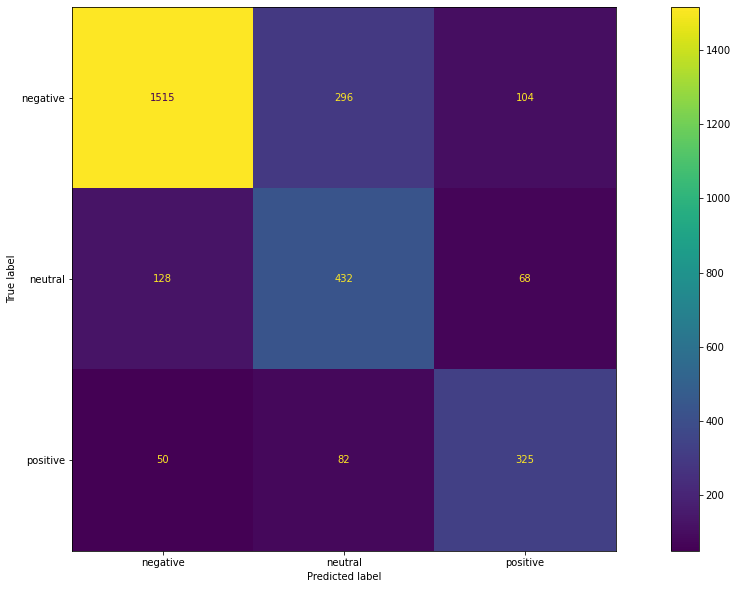

              precision    recall  f1-score   support

    negative       0.89      0.79      0.84      1915
     neutral       0.53      0.69      0.60       628
    positive       0.65      0.71      0.68       457

    accuracy                           0.76      3000
   macro avg       0.69      0.73      0.71      3000
weighted avg       0.78      0.76      0.77      3000

Berekeningstijd zonder metrics: 89.255s
Berekeningstijd per fit: 1.116s


In [165]:
# Logistic regression met hyperparametertuning en cross validation (grid search)
metrix_columns = ['Classifier', 'Accuracy', 'F1-score', 'Berekeningstijd', 'Berekeningstijd per fit']
metrix_arr = []

start_clf1 = timeit.default_timer()

clf1_gs = GridSearchCV(clf1, param1, cv=8, n_jobs=-1, scoring='accuracy', verbose=1)
clf1_gs.fit(X_train_tf, y_train)

stop_clf1 = timeit.default_timer()
diff_clf1 = stop_clf1 - start_clf1
diff_fit_clf1 = diff_clf1 / (len(ParameterGrid(param1)) * 8)

# Best parameters and score
print(f"Best parameters:\t{clf1_gs.best_params_}")
print(f"Best score: \t{clf1_gs.best_score_}")

# Confusion matrix
print("Confusion matrix")
clf1_pred = (clf1_gs.predict(X_test_tf))
ConfusionMatrixDisplay.from_predictions(y_test, clf1_pred)  
plt.show()

# Classification report
print(classification_report(y_test,clf1_pred))
clf1_accuracy = accuracy_score(y_test,clf1_pred)
clf1_f1 = f1_score(y_test,clf1_pred, average='weighted')

print(f'Berekeningstijd zonder metrics: {diff_clf1:.3f}s') # On Amazon SageMaker Studio Lab
print(f'Berekeningstijd per fit: {diff_fit_clf1:.3f}s') # On Amazon SageMaker Studio Lab

metrix_row_clf1 = ['Logistische Regressie', round(clf1_accuracy, 2), round(clf1_f1, 2), round(diff_clf1, 3), round(diff_fit_clf1, 3)]

Fitting 8 folds for each of 49 candidates, totalling 392 fits
Best parameters:	{'C': 100.0, 'gamma': 0.2, 'kernel': 'rbf'}
Best score: 	0.7671821305841924
Confusion matrix


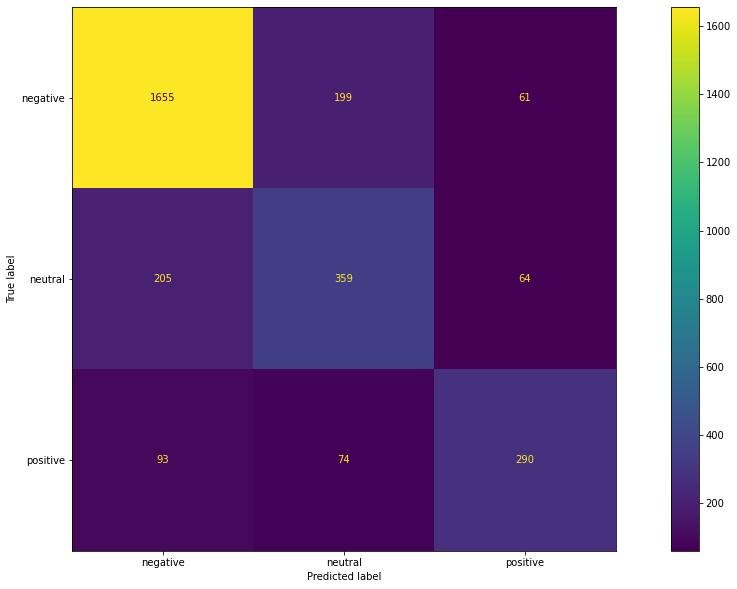

              precision    recall  f1-score   support

    negative       0.85      0.86      0.86      1915
     neutral       0.57      0.57      0.57       628
    positive       0.70      0.63      0.67       457

    accuracy                           0.77      3000
   macro avg       0.70      0.69      0.70      3000
weighted avg       0.77      0.77      0.77      3000

Berekeningstijd zonder metrics: 2376.093s
Berekeningstijd per fit: 6.061s


In [27]:
# SVM met hyperparametertuning en cross validation (grid search)
start_clf2 = timeit.default_timer()

clf2_gs = GridSearchCV(clf2, param2, cv=8, n_jobs=-1, scoring='accuracy', verbose=1)
clf2_gs.fit(X_train_tf, y_train)

stop_clf2 = timeit.default_timer()
diff_clf2 = stop_clf2 - start_clf2
diff_fit_clf2 = diff_clf2 / (len(ParameterGrid(param2)) * 8)

# Best parameters and score
print(f"Best parameters:\t{clf2_gs.best_params_}")
print(f"Best score: \t{clf2_gs.best_score_}")

# Confusion matrix
print("Confusion matrix")
clf2_pred = (clf2_gs.predict(X_test_tf))
ConfusionMatrixDisplay.from_predictions(y_test, clf2_pred)  
plt.show()

# Classification report
print(classification_report(y_test,clf2_pred))
clf2_accuracy = accuracy_score(y_test,clf2_pred)
clf2_f1 = f1_score(y_test,clf2_pred, average='weighted')

print(f'Berekeningstijd zonder metrics: {diff_clf2:.3f}s') # On Amazon SageMaker Studio Lab
print(f'Berekeningstijd per fit: {diff_fit_clf2:.3f}s') # On Amazon SageMaker Studio Lab

metrix_row_clf2 = ['Support Vector Classifier', round(clf2_accuracy, 2), round(clf2_f1, 2), round(diff_clf2, 3), round(diff_fit_clf2, 3)]

Fitting 8 folds for each of 6 candidates, totalling 48 fits
Best parameters:	{'alpha': 0.1}
Best score: 	0.738745704467354
Confusion matrix


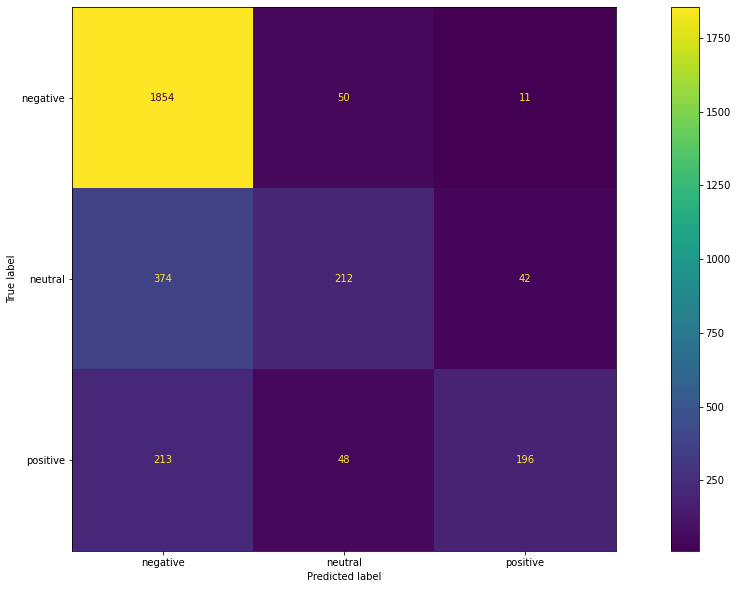

              precision    recall  f1-score   support

    negative       0.76      0.97      0.85      1915
     neutral       0.68      0.34      0.45       628
    positive       0.79      0.43      0.56       457

    accuracy                           0.75      3000
   macro avg       0.74      0.58      0.62      3000
weighted avg       0.75      0.75      0.72      3000

Berekeningstijd zonder metrics: 0.373s
Berekeningstijd per fit: 0.008s


In [168]:
# Naive Bayes met hyperparametertuning en cross validation (grid search)
start_clf3 = timeit.default_timer()

clf3_gs = GridSearchCV(clf3, param3, cv=8, n_jobs=-1, scoring='accuracy', verbose=1)
clf3_gs.fit(X_train_tf, y_train)

stop_clf3 = timeit.default_timer()
diff_clf3 = stop_clf3 - start_clf3
diff_fit_clf3 = diff_clf3 / (len(ParameterGrid(param3)) * 8)

# Best parameters and score
print(f"Best parameters:\t{clf3_gs.best_params_}")
print(f"Best score: \t{clf3_gs.best_score_}")

# Confusion matrix
print("Confusion matrix")
clf3_pred = (clf3_gs.predict(X_test_tf))
ConfusionMatrixDisplay.from_predictions(y_test, clf3_pred)  
plt.show()

# Classification report
print(classification_report(y_test,clf3_pred))
clf3_accuracy = accuracy_score(y_test,clf3_pred)
clf3_f1 = f1_score(y_test,clf3_pred, average='weighted')

print(f'Berekeningstijd zonder metrics: {diff_clf3:.3f}s') # On Amazon SageMaker Studio Lab
print(f'Berekeningstijd per fit: {diff_fit_clf3:.3f}s') # On Amazon SageMaker Studio Lab

metrix_row_clf3 = ['Naïve Bayes', round(clf3_accuracy, 2), round(clf3_accuracy, 2), round(diff_clf3, 3), round(diff_fit_clf3, 3)]

Welke classifier heeft jouw voorkeur? Beargumenteer in termen van accuracy, f1-score maar ook de berekeningstijd.


In [169]:
# Antwoord
metrix_arr = []
metrix_arr.append(metrix_row_clf1)
metrix_arr.append(metrix_row_clf2)
metrix_arr.append(metrix_row_clf3)
metrix_df = pd.DataFrame(metrix_arr, columns=metrix_columns)
metrix_df

,Classifier,Accuracy,F1-score,Berekeningstijd,Berekeningstijd per fit
0,Logistische Regressie,0.76,0.77,89.255,1.116
1,Support Vector Classifier,0.77,0.77,2376.093,6.061
2,Naïve Bayes,0.75,0.75,0.373,0.008


In [170]:
metrix_df.style.highlight_max(subset = ['Accuracy', 'F1-score'], color = 'green', axis = 0)


,Classifier,Accuracy,F1-score,Berekeningstijd,Berekeningstijd per fit
0,Logistische Regressie,0.760000,0.770000,89.255000,1.116000
1,Support Vector Classifier,0.770000,0.770000,2376.093000,6.061000
2,Naïve Bayes,0.750000,0.750000,0.373000,0.008000


In [171]:
metrix_df.style.highlight_min(subset = ['Berekeningstijd', 'Berekeningstijd per fit'], color = 'green', axis = 0)

,Classifier,Accuracy,F1-score,Berekeningstijd,Berekeningstijd per fit
0,Logistische Regressie,0.760000,0.770000,89.255000,1.116000
1,Support Vector Classifier,0.770000,0.770000,2376.093000,6.061000
2,Naïve Bayes,0.750000,0.750000,0.373000,0.008000


In de geteste modellen zijn logistische regressie en SVM gelijkaardig met betrekking tot de evaluatieparameters. Ze hebben beide een gewogen F1 score van 0.77 en een accuracy van 0.76 en 0.77 respectievelijk. Kijkend naar de berekeningstijd tussen deze 2, doet SVM er ongeveer 6x langer over per training. Met enkel een keuze tussen deze twee gaat de voorkeur uit naar logtistische regressie (zelfde accuracy, maar veel kortere berekeningstijd). Naïve bayes doet het in dit model iets slechter dan de andere 2 classifiers met een accuracy en F1-score van 0.72. Hiertegenover staat wel een zéér korte berekeningstijd van 0,041 seconde per training. Dat is 27x sneller dan logistische regressie en 148x sneller dan SVM. Deze kortere berekeningstijd pleit sterk in het voordeel van Naïve Bayes, ookal is de accuracy niet geweldig. Er moet trouwnes ook gezegd worden dat de accuracy van SVM en logistische regressie ook niet heel indrukwekkend is. De voorkeur zou alsnog naar Naïve Bayes gaan, mits de nodige model optimalisatie.

Hieraan toegevoegd hoort ook alvast een deel van het antwoord op de volgende vraag. Naïve Bayes is in staat om meer negatieve tweets correct te classificeren dan de overige 2 classifiers.

### Modeloptimalisatie

- Stel dat de airlines vooral geïnteresseerd zijn in het correct opsporen van negatieve tweets. Welke aanpassingen zou je kunnen doen om ervoor te zorgen dat het model minder negatieve tweets verkeerd classificeert? Test deze aanpassingen.

- Bekom je een beter model met een hogere accuraatheid wanneer je ook de feature airline in rekening brengt? Een optie hierbij is ook om voor elke airline een apart model te trainen. 

- Bekom je een beter model wanneer je de lengte van de tweets in rekening brengt?

#### Reduceren van vals-negatieve predicties
Als de airlines vooral geïnteresseerd zijn in het correct opsporen van negatieve tweets, dan is de snelste manier voor het reduceren van het aantal vals-negatieve tweets enerzijds het bundelen van de neutrale en positieve tweets. Zodoende wordt een binaire classificatie getraind, waarbij doormiddel van het verplaatsen van de treshold, het aantal valsnegatieve tweets kan worden gereduceerd. Deze aanpassingen worden getest op logistische regressie en Naïve Bayes. Vanwege tijdsefficiëntie, wordt voor modeloptimalisatie geen SVM meer gebruikt.

Belangrijk: in de volgende modellen wordt klasse "1" toegekend aan de tweets met negatieve sentiment. Klasse "0" wordt toegekend aan alle andere tweets. Op basis van deze hernoeming kan de vraag uit de opdracht worden veranderd tot het reduceren van valspositieve resultaten. Hiervoor kan een ROC-curve worden aangewend.

In [172]:
# Combineren van neutrale en positieve berichten
y_train_bin = np.where(y_train == 'negative', 1, 0)
y_test_bin = np.where(y_test == 'negative', 1, 0)

Fitting 8 folds for each of 10 candidates, totalling 80 fits


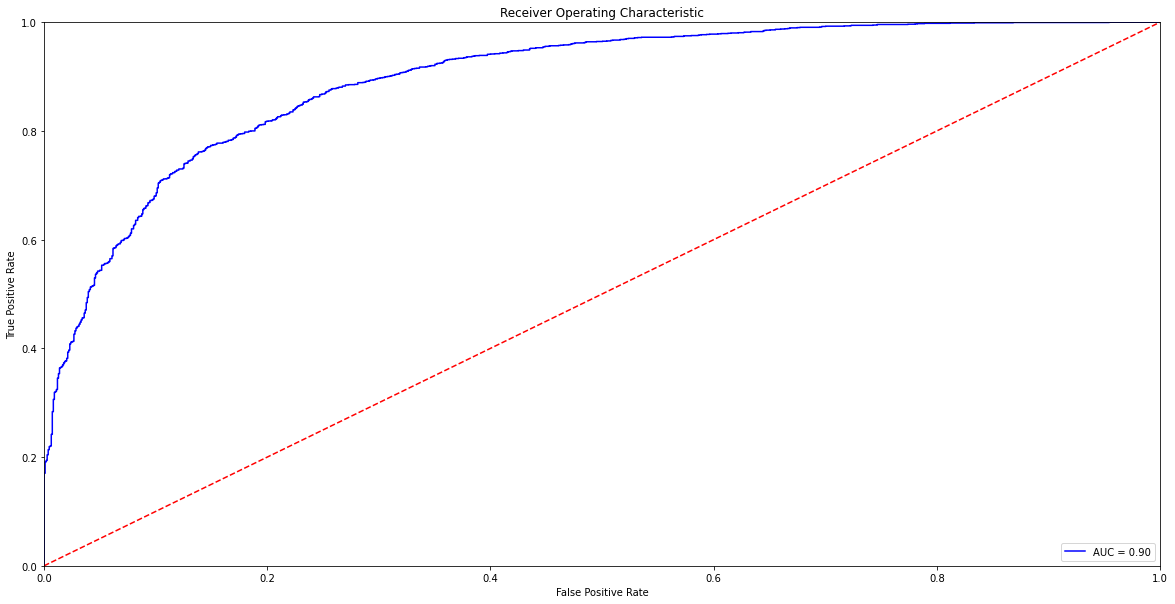

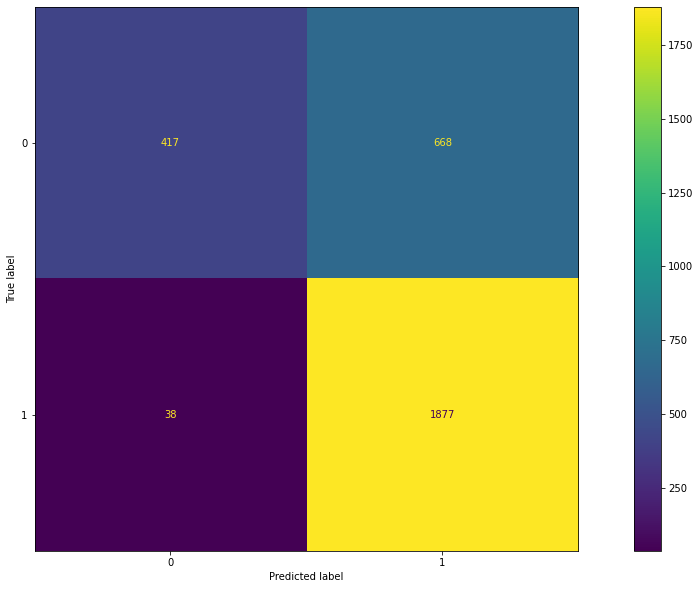

              precision    recall  f1-score   support

           0       0.92      0.38      0.54      1085
           1       0.74      0.98      0.84      1915

    accuracy                           0.76      3000
   macro avg       0.83      0.68      0.69      3000
weighted avg       0.80      0.76      0.73      3000



In [173]:
# Logistische regressie
clf1_gs = GridSearchCV(clf1, param1, cv=8, n_jobs=-1, scoring='accuracy', verbose=1)
clf1_gs.fit(X_train_tf, y_train_bin)

#ROC
probs = clf1_gs.predict_proba(X_test_tf)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test_bin, preds)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Confusion matrix
y_pred_bin = (clf1_gs.predict_proba(X_test_tf)[:,1] >= 0.1)
ConfusionMatrixDisplay.from_predictions(y_test_bin.astype(int), y_pred_bin.astype(int))  
plt.show()

print(classification_report(y_test_bin,y_pred_bin))

Fitting 8 folds for each of 6 candidates, totalling 48 fits


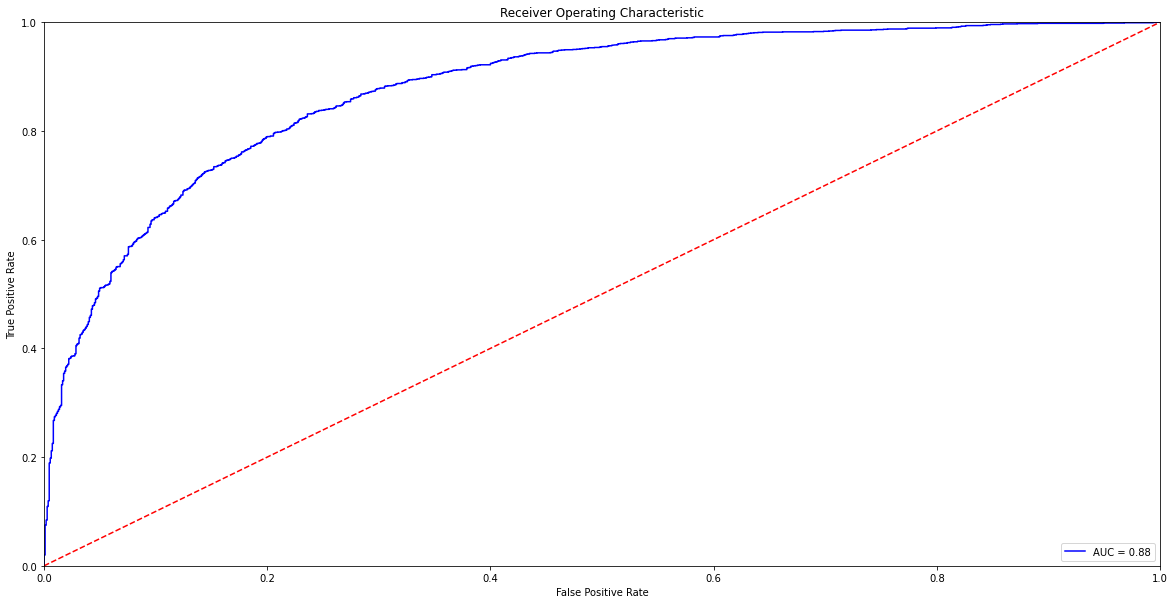

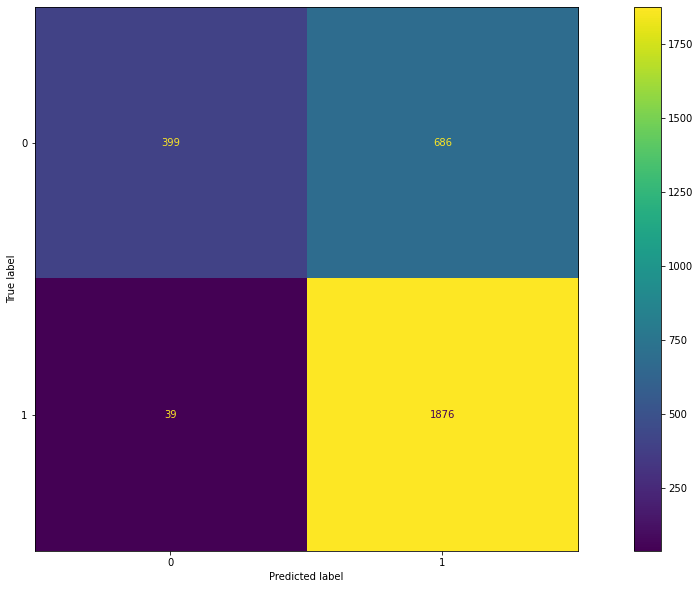

              precision    recall  f1-score   support

           0       0.91      0.37      0.52      1085
           1       0.73      0.98      0.84      1915

    accuracy                           0.76      3000
   macro avg       0.82      0.67      0.68      3000
weighted avg       0.80      0.76      0.72      3000



In [174]:

# Naive bayes na combineren neutrale en positieve berichten
clf3_gs = GridSearchCV(clf3, param3, cv=8, n_jobs=-1, scoring='accuracy', verbose=1)
clf3_gs.fit(X_train_tf, y_train_bin)

#ROC
probs = clf3_gs.predict_proba(X_test_tf)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test_bin, preds)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Confusion matrix
y_pred_bin = (clf3_gs.predict_proba(X_test_tf)[:,1] >= 0.3)
ConfusionMatrixDisplay.from_predictions(y_test_bin.astype(int), y_pred_bin.astype(int))  
plt.show()

print(classification_report(y_test_bin,y_pred_bin))


Zoals reeds eerder vermeld, lijkt Naïve Bayes het iets beter te doen bij het reduceren van tweets die valselijk zijn geclassificeerd als neutraal of positief. De Threshold hoeft niet zo sterk worden verlaagd (klasse 1 = negatieve sentiment) als bij logistische regressie: 0.3 versus 0.1. De threshold verhogen zorgt voor een lichte toename aan accuracy bij Naïve Bayes (72% naar 76%). Bij logistische regressie boet de accuracy niet in bij het verlagen tot een threshold van 0.1. Het gevolg van deze aanpassing is een uitgesproken toename van neutrale of positieve tweets, die als negatief worden afgegeven in deze modellen.

#### Feature airline integreren in model
In principe is de airline reeds geïntegreerd in de modellen. Het eerste woord van elke tweet start met de aanhef tot een bepaalde airline maatschappij. In deze zin lijkt het nutteloos om de airline toe te voegen aan 

In [129]:
X_train_airline = pd.DataFrame(X_train.todense(), index=y_train.index, columns=countvect.get_feature_names())


AttributeError: 'numpy.ndarray' object has no attribute 'index'

In [131]:
X

0                                                                            virginamerica dhepburn said 
1                                                            virginamerica plus ad commerci experi tacki 
2                                                     virginamerica today must mean need take anoth trip 
3                           virginamerica realli aggress blast obnoxi entertain guest face littl recours 
4                                                                     virginamerica realli big bad thing 
                                                       ...                                               
14635                                                        americanair thank got differ flight chicago 
14636     americanair leav minut late flight warn communic minut late flight that call shitti custom svc 
14637                                                 americanair pleas bring american airlin blackberri 
14638                                    ameri


- Bekom je een beter model met een hogere accuraatheid wanneer je ook de feature airline in rekening brengt? Een optie hierbij is ook om voor elke airline een apart model te trainen. 

- Bekom je een beter model wanneer je de lengte van de tweets in rekening brengt?

In [130]:
print(X_train)

  (0, 8563)	0.13710847475039215
  (0, 8438)	0.3166381072977742
  (0, 5854)	0.3453505514957026
  (0, 2563)	0.30428854020714213
  (0, 2316)	0.362180875982534
  (0, 1267)	0.362180875982534
  (0, 957)	0.3797900443590422
  (0, 592)	0.2381545449065354
  (0, 428)	0.3182285373175028
  (0, 383)	0.32327328248194825
  (1, 9102)	0.3092355173794466
  (1, 8563)	0.10074516580726085
  (1, 8338)	0.30600970129510613
  (1, 7228)	0.16169133900469287
  (1, 6807)	0.32288859098171413
  (1, 5438)	0.3730631133061951
  (1, 3778)	0.380999314950034
  (1, 3741)	0.15563962004692722
  (1, 3284)	0.21377983160635178
  (1, 3181)	0.1421455621117167
  (1, 1775)	0.16389139061185293
  (1, 1597)	0.2556718444547585
  (1, 1453)	0.153670533646359
  (1, 399)	0.380999314950034
  (1, 162)	0.1863054316122722
  :	:
  (11636, 6155)	0.28761709773619254
  (11636, 3541)	0.23121301151507906
  (11636, 1654)	0.32096006718772063
  (11636, 46)	0.6146479478178797
  (11637, 9170)	0.4298008952751069
  (11637, 8672)	0.2172242376509199
  (11637,

In [178]:
# Toevoegen tweet length
char_length = np.vectorize(len)
train_len  = char_length(X_train)
test_len  = char_length(X_test)

X_train_len = csr_matrix(np.append(X_train_tf.todense(), train_len.reshape(-1,1), axis=1))
X_test_len = csr_matrix(np.append(X_test_tf.todense(), test_len.reshape(-1,1), axis=1))


In [179]:
X_train_len

<11640x9486 sparse matrix of type '<class 'numpy.float64'>'
	with 125003 stored elements in Compressed Sparse Row format>

##  Cyber trolls

Een cyber troll heeft als bedoeling emotionele reacties uit te lokken door opzettelijk verkeerde, kwetsende en agressieve berichten te plaatsen op forums, newsgroups, social media, etc. Online platformen hebben er een groot belang bij om deze cyber trolls te kunnen detecteren en weren van hun platform. Daarvoor gebruiken ze geavanceerde nlp algoritmes. Ontwerp zelf een cyber troll detector op basis. Je kan daarvoor beroep doen op de dataset 'Cybetrolls.csv'. Om de dataset te evalueren gebruik je een test set van 5000 berichten.

Welke woorden worden het meest door cyber trolls gebruikt? Geef een top 10.
Welke woorden dragen voor een logistic classifier het meest bij tot klasse 'troll bericht'? Geef ook hier een top 10.

Voor het evalueren van de classifier gebruik je de volgende metrics: accuracy, f1 score en de ROC. Formuleer conclusies. Bijvoorbeeld naar de keuze toe van de classifier, interpretatie van de ROC of auROC. Toon enkele verkeerd geclassificeerde berichten en probeer te achterhalen waarom ze verkeerd geclassificeerd werden.





In [32]:
dataset = pd.read_csv('Cybetrolls.csv')
dataset.head()

,annotation,content
0,1,Get fucking real dude.
1,1,She is as dirty as they come and that crook Rengel the Dems are so fucking corrupt it's a joke. Make Republicans look like ...
2,1,why did you fuck it up. I could do it all day too. Let's do it when you have an hour. Ping me later to sched writing a book here.
3,1,Dude they dont finish enclosing the fucking showers. I hate half assed jobs. Whats the reasononing behind it? Makes no sense.
4,1,WTF are you talking about Men? No men thats not a menage that's just gay.
